In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

E:\Ana\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ana\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\Ana\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
# Load VIX data
vix_data = pd.read_csv('vix_data.csv', index_col=0)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(vix_data)

In [5]:
# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create X and Y data sets for training and testing
def create_dataset(dataset, time_step=1):
    X_data, Y_data = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X_data.append(a)
        Y_data.append(dataset[i + time_step, 0])
    return np.array(X_data), np.array(Y_data)

time_step = 10
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the input data to be 3-dimensional for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# Construct LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
105/105 [==============================] - 8s 25ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 2/100
105/105 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 3/100
105/105 [==============================] - 2s 15ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 4/100
105/105 [==============================] - 2s 15ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 5/100
105/105 [==============================] - 2s 16ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 6/100
105/105 [==============================] - 2s 15ms/step - loss: 9.0195e-04 - val_loss: 0.0015
Epoch 7/100
105/105 [==============================] - 2s 15ms/step - loss: 8.4596e-04 - val_loss: 0.0014
Epoch 8/100
105/105 [==============================] - 2s 17ms/step - loss: 7.7187e-04 - val_loss: 0.0011
Epoch 9/100
105/105 [==============================] - 2s 16ms/step - loss: 6.6269e-04 - val_loss: 9.9205e-04
Epoch 10/100
105/105 [==============================] - 2s 16m

In [7]:
# Make predictions using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the scaled data to get actual values
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

52/52 [==============================] - 0s 5ms/step


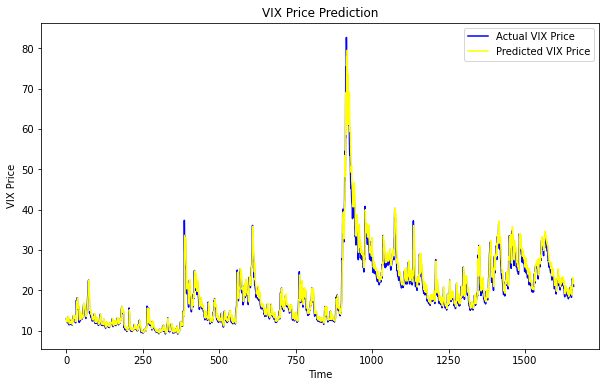

In [11]:
# Plot the predicted versus actual values of VIX closed price on the test set
plt.figure(figsize=(10, 6))
plt.plot(Y_test[0], color='blue', label='Actual VIX Price')
plt.plot(test_predict[:, 0], color='yellow', label='Predicted VIX Price')
plt.title('VIX Price Prediction')
plt.xlabel('Time')
plt.ylabel('VIX Price')
plt.legend()
plt.show()

In [9]:
# Calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
r2 = r2_score(Y_test[0], test_predict[:, 0])
medae = median_absolute_error(Y_test[0], test_predict[:, 0])

# Create a summary table
summary = pd.DataFrame({'Metric': ['Test RMSE', 'Test MAE', 'Test R-squared', 'Test Median absolute error'],
                        'Value': [rmse, mae, r2, medae]})

# Print the summary table
print(summary)

                       Metric     Value
0                   Test RMSE  2.172927
1                    Test MAE  1.345269
2              Test R-squared  0.932726
3  Test Median absolute error  0.864500
